## <span style='color:#ff5f27'> 📝 Imports</span>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
from functools import partial
from torch.utils.tensorboard import SummaryWriter

from functions.t5 import encode_text
from functions.vqgan import load_vqgan_model, load_process_encode_rgb_image
import config

## <span style='color:#ff5f27'> 🤖 Model Loading</span>

In [2]:
# Load COCO VQGAN
vqgan_model = load_vqgan_model(
    config.VQGAN_CONFIG_COCO,
    config.VQGAN_CHECKPOINT_COCO,
).to(config.DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2021-01-20T16-04-20_coco_transformer/coco_cond_stage.ckpt
2024-09-03 19:03:58,066 INFO: number of parameters: 6.513075e+08
Restored from logs/2021-01-20T16-04-20_coco_transformer/model_ckpt/last.ckpt
✅ Done!


## <span style='color:#ff5f27'> ⚙️ Text Encoding</span>

In [3]:
input_text = [
    config.PROMPT,
]

In [4]:
text_token_embeds, text_mask = encode_text(
    config.PROMPT, 
    name='t5-large', 
    output_device=config.DEVICE,
)
text_token_embeds.shape

/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


torch.Size([39, 3, 1024])

## <span style='color:#ff5f27'> 🗄️ Data Loader</span>

In [5]:
class TextImageDataset(Dataset):
    def __init__(self, json_file, img_dir, transform=None, min_dim=256):
        with open(json_file, 'r') as f:
            data = json.load(f)
        self.annotations = data['annotations']
        self.img_dir = img_dir
        self.transform = transform
        self.min_dim = min_dim

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_id = ann['image_id']
        caption = ann['caption']
        
        img_name = f"{img_id:012d}.jpg"
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            with Image.open(img_path) as img:
                if min(img.size) < self.min_dim:
                    return None
                image = img.convert('RGB')
            
            if self.transform:
                image = self.transform(image)
            return caption, image, img_path
        except (IOError, OSError):
            return None

    def visualize_sample(self, idx):
        item = self[idx]
        if item is None:
            print(f"Unable to visualize sample at index {idx}")
            return

        caption, image_tensor, _ = item
        
        fig, ax = plt.subplots(figsize=(8, 6))
        
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        image = image_tensor.clone()
        for t, m, s in zip(image, mean, std):
            t.mul_(s).add_(m)
        
        image = image.numpy().transpose(1, 2, 0)
        image = np.clip(image, 0, 1)
        
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        
        plt.figtext(0.5, 0.05, caption, wrap=True, horizontalalignment='center', fontsize=12)
        plt.show()

def collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x is not None, batch))
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)

In [6]:
# Create dataset and dataloader
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = TextImageDataset(
    json_file='mc_coco/annotations/captions_val2017.json', 
    img_dir='mc_coco/val2017', 
    transform=transform,
)

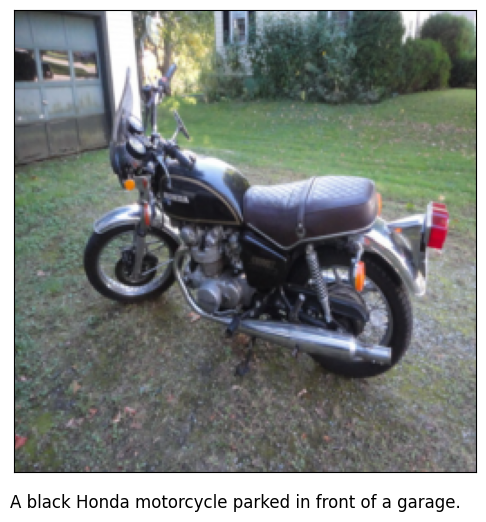

In [7]:
dataset.visualize_sample(0)

In [8]:
# Split the validation dataset into training and validation subsets
train_size = int(0.8 * len(dataset))  # Use 80% for training
val_size = len(dataset) - train_size  # Use 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Total dataset size: {len(dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn, pin_memory=True)

### INCREASE BATCH SIZE TO 32

Total dataset size: 25014
Training set size: 20011
Validation set size: 5003




## <span style='color:#ff5f27'> 🧬 Transistor Architecture</span>

In [9]:
class Transistor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Transistor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

## <span style='color:#ff5f27'> 🏃🏻‍♂️ Transistor Training</span>

In [10]:
@torch.no_grad()
def preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device):
    text_latents, _ = encode_text_fn(captions)
    text_latents = text_latents.mean(dim=1)  # Average over token dimension

    image_latents = []
    for img_path in img_paths:
        z, _ = load_process_encode_rgb_image(img_path, vqgan_model, device=device)
        image_latents.append(z.view(1, -1))  # Flatten to [1, 256*16*16]
    image_latents = torch.cat(image_latents, dim=0)

    return text_latents.to(device), image_latents.to(device)

In [11]:
@torch.no_grad()
def validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn):
    transistor_model.eval()
    total_loss = 0
    for captions, _, img_paths in val_loader:
        text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
        outputs = transistor_model(text_latents)
        loss = criterion(outputs, image_latents)
        total_loss += loss.item()
    return total_loss / len(val_loader)

def visualize_results(transistor_model, vqgan_model, text_input, device, encode_text_fn):
    transistor_model.eval()
    with torch.no_grad():
        text_latent, _ = encode_text_fn([text_input])
        text_latent = text_latent.mean(dim=1).to(device)
        image_latent = transistor_model(text_latent)
        image = vqgan_model.decode(image_latent.view(1, 256, 16, 16))
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title(text_input)
    plt.axis('off')
    plt.show()

In [12]:
def train_model(transistor_model, train_loader, val_loader, vqgan_model, criterion, optimizer, device, num_epochs=10, accumulation_steps=4):
    transistor_model.train()
    scaler = torch.cuda.amp.GradScaler()
    encode_text_fn = partial(encode_text, name='t5-large', output_device=device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    writer = SummaryWriter()
    
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (captions, _, img_paths) in enumerate(pbar):
            text_latents, image_latents = preprocess_batch(captions, img_paths, vqgan_model, encode_text_fn, device)
            
            with torch.cuda.amp.autocast():
                outputs = transistor_model(text_latents)
                loss = criterion(outputs, image_latents)
            
            scaler.scale(loss).backward()
            
            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss / (i + 1)})
        
        avg_train_loss = running_loss / len(train_loader)
        val_loss = validate(transistor_model, val_loader, vqgan_model, criterion, device, encode_text_fn)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        writer.add_scalar('Loss/train', avg_train_loss, epoch)
        writer.add_scalar('Loss/val', val_loss, epoch)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transistor_model.state_dict(), 'best_transistor_model.pth')
            print(f"💾 Saved best model with validation loss: {best_val_loss:.4f}")
        
        if (epoch + 1) % 5 == 0:
            visualize_results(transistor_model, vqgan_model, "A cat sitting on a couch", device, encode_text_fn)
    
    writer.close()
    print("✅ Training completed.")

In [13]:
# Initialize Transistor model
input_dim = 1024  # Dimension of T5 output
hidden_dim = 2048
output_dim = 256 * 16 * 16  # Dimension of VQGAN latent space (assuming 16x16 spatial dimensions)
transistor_model = Transistor(input_dim, hidden_dim, output_dim).to(config.DEVICE)

In [14]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(transistor_model.parameters(), lr=0.001, weight_decay=0.01)

In [ ]:
# Train the model
train_model(
    transistor_model, 
    train_loader, 
    val_loader, 
    vqgan_model, 
    criterion, 
    optimizer, 
    config.DEVICE, 
    num_epochs=10, 
    accumulation_steps=4,
)

Epoch 1/10:   0%|          | 0/2502 [00:00<?, ?it/s]/srv/hops/anaconda/envs/theenv/lib/python3.10/site-packages/torchvision/transforms/functional.py:442: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(
Epoch 1/10: 100%|██████████| 2502/2502 [36:37<00:00,  1.14it/s, loss=0.601]


Epoch [1/10], Train Loss: 0.6009, Val Loss: 0.5985
💾 Saved best model with validation loss: 0.5985


Epoch 2/10: 100%|██████████| 2502/2502 [36:18<00:00,  1.15it/s, loss=0.596]


Epoch [2/10], Train Loss: 0.5960, Val Loss: 0.5971
💾 Saved best model with validation loss: 0.5971


Epoch 3/10: 100%|██████████| 2502/2502 [36:17<00:00,  1.15it/s, loss=0.593]


Epoch [3/10], Train Loss: 0.5935, Val Loss: 0.5956
💾 Saved best model with validation loss: 0.5956


Epoch 4/10:  13%|█▎        | 327/2502 [04:50<31:46,  1.14it/s, loss=0.591] 

## <span style='color:#ff5f27'> 💾 Transistor Saving</span>

In [ ]:
# Save the trained model
torch.save(transistor_model.state_dict(), 'transistor_model.pth')

---

In [ ]:
def generate_image_from_text(text, transistor_model, vqgan_model, t5_encoder, device):
    # Encode text
    text_latent, _ = t5_encoder([text])
    text_latent = text_latent.mean(dim=1).to(device)  # Average over token dimension

    # Pass through Transistor
    with torch.no_grad():
        image_latent = transistor_model(text_latent)

    # Reshape
    image_latent = image_latent.view(1, 256, 16, 16)

    # Quantize (this step depends on VQGAN's specific implementation)
    quant_latent = vqgan_model.quantize(image_latent)

    # Decode
    image = vqgan_model.decode(quant_latent)

    return image

---